<a href="https://colab.research.google.com/github/HoseinNekouei/US_Airline_Sentiment_Classification/blob/main/pyTorch_US_airline_tweet_fine_tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libreries and important requirment**

In [2]:
import os
import gc

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir /content/dataset
!cp /content/drive/MyDrive/Projects/Sentiment_Analysis/Augmented_dataset_US_airline_Tweet.csv /content/dataset

# **Load Dataset and Pre-Processing data**

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

class DataVisualizer:
    @staticmethod
    def visualize_sentiment(data):
        sentiment_count = data.airline_sentiment.value_counts()
        colors = sns.color_palette('pastel', 3)
        labels = ['Negative', 'Neutral', 'Positive']
        explode = [0.01, 0.01, 0.01]

        plt.figure(figsize=(4, 4))
        sentiment_count.plot(
            kind='pie',
            colors=colors,
            labels=labels,
            explode=explode,
            shadow=True,
            autopct='%.2f',
            fontsize=12,
        )
        plt.title('Total Tweets for Each Sentiment')
        plt.ylabel(' ')
        plt.show()

In [5]:
import logging
import string
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

class TextProcessor:
    @staticmethod
    def class_mapping(sentiment: str)-> int:
        """ Map class labels to new values."""

        if sentiment== 'negative':
          return 0
        elif sentiment== 'neutral':
          return 1
        elif sentiment== 'positive':
          return 2
        else:
          logging.warning(f'Unknown Sentiment {sentiment}')
          return -1

    @staticmethod
    def remove_stopwords(text):
        """
          Stop words are commonly used words in a language that are often filtered out in text processing
          because they carry little meaningful information on their own.
          Examples in English include words like "the," "is," "in," "and," "a," etc.
          They are typically removed in Natural Language Processing (NLP) tasks to improve the efficiency of algorithms or the quality of analysis.
        """
        text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
        return text

    # Remove url
    @staticmethod
    def remove_urls(text):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'',text)

    # Remove html
    @staticmethod
    def remove_html(text):
        html=re.compile(r'<.*?>')
        return html.sub(r'',text)

    # Remove @username
    @staticmethod
    def remove_username(text):
        return re.sub('@[^\s]+','',text)

    # Decontraction text
    @staticmethod
    def decontraction(text):
        text = re.sub(r"won\'t", " will not", text)
        text = re.sub(r"won\'t've", " will not have", text)
        text = re.sub(r"can\'t", " can not", text)
        text = re.sub(r"don\'t", " do not", text)
        text = re.sub(r"didn\'t", " did not", text)
        text = re.sub(r"can\'t've", " can not have", text)
        text = re.sub(r"ma\'am", " madam", text)
        text = re.sub(r"let\'s", " let us", text)
        text = re.sub(r"ain\'t", " am not", text)
        text = re.sub(r"shan\'t", " shall not", text)
        text = re.sub(r"sha\n't", " shall not", text)
        text = re.sub(r"o\'clock", " of the clock", text)
        text = re.sub(r"y\'all", " you all", text)
        text = re.sub(r"n\'t", " not", text)
        text = re.sub(r"n\'t've", " not have", text)
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'s", " is", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r"\'d've", " would have", text)
        text = re.sub(r"\'ll", " will", text)
        text = re.sub(r"\'ll've", " will have", text)
        text = re.sub(r"\'t", " not", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"\'m", " am", text)
        text = re.sub(r"\'re", " are", text)
        return text

    @staticmethod
    def normalize_repeated_chars(text):
        # Step 1: Preserve ellipses by temporarily replacing them with a unique placeholder
        placeholder = "<ELLIPSIS>"
        text = re.sub(r'\.{3,}', placeholder, text)  # Replace ellipses with a placeholder

        # Step 2: Normalize repeated characters. Matches any character repeated 3 or more times like cooool -> cool
        text = re.sub(r'(.)\1{2,}', r'\1', text)

        # Step 3: Restore ellipses by replacing the placeholder with '...'
        text = text.replace(placeholder, '...')
        return text

    @staticmethod
    # Separate alphabetic characters and numeric characters to improce tokenization
    def seperate_alphanumeric(text):
        words = re.findall(r"[^\W\d_]+|\d+|\W+", text)
        return " ".join(words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
import pandas as pd
from typing import Optional

class DatasetLoader:
    def __init__(self, *, file_path: str):
        self.file_path: str = file_path
        self._data: Optional[pd.DataFrame] = None

    def loader(self) -> None:
        if not os.path.exists(self.file_path):
            raise FileNotFoundError(f"File not found: {self.file_path}")
        self._data = pd.read_csv(self.file_path)

    def visualize_data(self):
        if self._data is not None:
            DataVisualizer.visualize_sentiment(self._data)
        else:
            raise ValueError("Data not loaded. Call `loader()` first.")

    def map_classes(self):
        if self._data is not None:
            # Apply the static method to map classes
            self._data['labels']= self._data['airline_sentiment'].apply(TextProcessor.class_mapping)
        else:
            raise ValueError("Data not loaded. Call `loader()` first.")

    def text_preprocessing(self):
        if self._data is not None:
            # Apply the static method to remove html
            self._data['revised_text']= self._data['text'].apply(TextProcessor.remove_html)

            # Apply the static method to remove urls
            self._data['revised_text']= self._data['revised_text'].apply(TextProcessor.remove_urls)

            # Apply the static method to decontract text.
            self._data['revised_text']= self._data['revised_text'].apply(TextProcessor.decontraction)

            # Convert texts to lowercase.
            self._data['revised_text']= self._data['revised_text'].apply(lambda x: x.lower())

            # Replace Repeated Characters with a Single Instance
            self._data['revised_text']= self._data['revised_text'].apply(TextProcessor.normalize_repeated_chars)

            # Separate alphabetic characters and numeric characters
            # self._data['revised_text']= self._data['revised_text'].apply(TextProcessor.seperate_alphanumeric)

            # Apply the static method to remove stop words
            # self._data['revised_text']= self._data['revised_text'].apply(TextProcessor.remove_stopwords)

            # Apply the static method to remove @username
            # self._data['revised_text']= self._data['revised_text'].apply(TextProcessor.remove_username)
        else:
            raise ValueError("Data not loaded. Call 'loader()' first")

    def __str__(self):
        if self._data is None:
            return "Data not loaded."
        information = [
            f'Categories of : {self._data.airline_sentiment.value_counts().to_dict()}',
            f'\nInformation: {self._data.info()}'
        ]
        return ', '.join(information)

    def __call__(self):
        self.loader()
        self.visualize_data()
        self.map_classes()
        self.text_preprocessing()


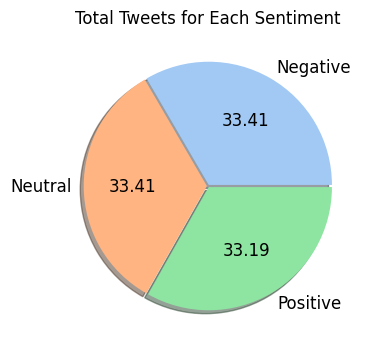

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54231 entries, 0 to 54230
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text               54231 non-null  object
 1   airline_sentiment  54231 non-null  object
 2   negativereason     18117 non-null  object
 3   positivereason     17997 non-null  object
 4   labels             54231 non-null  int64 
 5   revised_text       54231 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.5+ MB
Categories of : {'neutral': 18117, 'negative': 18117, 'positive': 17997}, 
Information: None


In [7]:
file_path= '/content/dataset/Augmented_dataset_US_airline_Tweet.csv'
loader= DatasetLoader(file_path= file_path)
loader()

print(loader)

# Split data into Trainset and Testset

In [8]:
from sklearn.model_selection import train_test_split

def split_dataset(*,features, labels):
  X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, stratify= labels, random_state= 42)

  message_list= [
    f'X_train length: {len(X_train)}',
    f'X_test length: {len(X_test)}',
    f'y_train length: {len(y_train)}',
    f'y_test length: {len(y_test)}'
  ]
  message_list= ','.join(message_list)
  print(message_list)

  return X_train, X_test, y_train, y_test


features= loader._data['revised_text']
labels= loader._data['labels']

X_train, X_test, y_train, y_test= split_dataset(features= features, labels= labels)

X_train length: 40673,X_test length: 13558,y_train length: 40673,y_test length: 13558


#**Loade Tokenizer and Tokenize tweets**

In [9]:
import torch
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [ ]:
# from transformers import pipeline
# flan_model_name= "google/flan-t5-large"
# generator = pipeline('text2text-generation', model= flan_model_name )

# if not isinstance(X_train, list):
#   X_train= X_train.tolist()

# # Define a prompt
# prompt= 'Provide a brief explanation the interpretation of the key emotional aspects and tone: '

# augmented_tweets= []

# for tweet in X_train:
#   result= generator(prompt + tweet)
#   augmented_tweet= f"{tweet} T, {result[0]['generated_text']}"
#   augmented_tweets.append(augmented_tweet)

# augmented_tweets


# **Load Model and make new augmented dataset of X_train**

In [10]:
from transformers import T5ForConditionalGeneration, T5TokenizerFast

flan_model_name= "google/flan-t5-large"
device= 'cuda' if torch.cuda.is_available() else 'cpu'

flan_model= T5ForConditionalGeneration.from_pretrained(flan_model_name, device_map='auto', torch_dtype= torch.float16)
flan_tokenizer= T5TokenizerFast.from_pretrained(flan_model_name)

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [ ]:
from google.colab import output

def tweet_augmentation(tweets, batch_size= 32):
    # Define a prompt
    prompt= 'Provide a brief explanation the interpretation of the key emotional aspects and tone: '
    augmented_tweets= []

    for i in range(0, len(tweets), batch_size):
        batch= tweets[i: i+ batch_size]
        prompts= [prompt + tweet  for tweet in batch]

        #Tokenize and generate
        inputs= flan_tokenizer(
            prompts,
            return_tensors= 'pt',
            padding= True,
            truncation= True).to(device)

        outputs= flan_model.generate(
            **inputs,
            max_length= 50,
            num_return_sequences=1,)
            # num_beams= 5,
            # early_stopping=True)

        #Decode and combine
        generated_tweets= flan_tokenizer.batch_decode(outputs, skip_special_tokens= True)

        output.clear()
        print(f'generate {i}/{len(tweets)} tweets')

        for original_tweet, generated_tweet in zip(batch, generated_tweets):
            augmented_tweets.append(f"{original_tweet} [START_ASPECT] {generated_tweet} [END_ASPECT]")

    return augmented_tweets

augmented_X_train= tweet_augmentation(X_train, batch_size= 64)

generate 11520/40673 tweets


In [ ]:
!pip install datasets

In [ ]:
from datasets import Dataset
import pandas as pd

# Create a Hugging Face Dataset
augmented_dataset = Dataset.from_dict({
    "text": augmented_X_train,
    "labels": y_train
})

raw_data= pd.DataFrame(augmented_dataset)
raw_data.to_csv("/content/drive/MyDrive/Projects/Sentiment_Analysis/augmented_X_train.csv", index=False)

texts= raw_data['text']
labels= raw_data['labels']

# **Sentiment Analysis block**

In [ ]:
del flan_model
del flan_tokenizer

gc.collect()
torch.cuda.empty_cache()

In [ ]:
X_train, X_val, y_train, y_val= train_test_split(texts, labels, test_size=0.2, stratify= labels)
len(X_train), len(y_train), len(X_val), len(y_val)

y_train= y_train.tolist()
y_val= y_val.tolist()

In [ ]:
from transformers import  AutoTokenizer,AutoModelForSequenceClassification
from torch.optim import AdamW

check_point= 'cardiffnlp/twitter-roberta-base-sentiment-latest'

sentiment_tokenizer = AutoTokenizer.from_pretrained(check_point)
sentiment_model= AutoModelForSequenceClassification.from_pretrained(check_point, device_map='auto')
optim = AdamW(sentiment_model.parameters(), lr=1e-12)

In [ ]:
class CreateDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings= encodings
    self.labels= labels

  def __getitem__(self, idx):
    item= {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

def tokenize(texts):
    if not isinstance(texts, list):
        texts= texts.tolist()

    train_encoding= sentiment_tokenizer(
        texts,
        padding=True,
        max_length=256,
        truncation= True)

    return train_encoding

train_encoding= tokenize(X_train)
validation_encoding= tokenize(X_val)

trainset= CreateDataset(train_encoding, y_train)
valset= CreateDataset(validation_encoding, y_val)

# Create DataLoader
batch_size= 128
train_loader= DataLoader(trainset, batch_size= batch_size, shuffle= True)
val_loader= DataLoader(valset, batch_size= batch_size)

In [ ]:
import math

epochs= 5
best_loss= float('inf')
patience = 2  # Number of epochs to wait for improvement
epochs_without_improvement = 0
accumulation_steps = 4  # Number of batches to accumulate gradients over

for epoch in range(epochs):
  total_loss, train_loss, val_loss = 0, 0, 0
  total_acc, train_acc, val_acc = 0, 0 , 0

  # Set model to training mode
  sentiment_model.train()

  optim.zero_grad()   # Clear gradients before starting accumulation
  for i, batch in enumerate(train_loader):

    # Using GPU
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    # Forward pass
    outputs = sentiment_model(input_ids, attention_mask=attention_mask, labels=labels)
    y_pred = torch.argmax(outputs.logits, dim=1)

    # Compute loss
    loss = outputs[0]

    # Backward pass and optimization
    loss.backward()

    # Update model parameters after `accumulation_steps` batches
    if (i + 1) % accumulation_steps == 0:
        optim.step()       # Update model parameters
        optim.zero_grad()  # Clear gradients for the next accumulation cycle

    # Accumulate loss and accuracy
    train_loss += loss.item() * len(batch['input_ids'])
    train_acc += torch.sum(y_pred == labels).item()

    if (i + 1) % 10 == 0:
      print(f' batch: [{i + 1}/{math.floor(len(trainset)/batch_size)}]')

  # Average loss and accuracy for training
  train_loss /= len(trainset)
  train_acc /= len(trainset)


  # Set model to evaluation mode
  sentiment_model.eval()

  with torch.no_grad():
    for batch in val_loader:

      # Using GPU
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      # Forward pass
      outputs = sentiment_model(input_ids, attention_mask=attention_mask, labels=labels)
      y_pred= torch.argmax(outputs.logits, dim=1)

      # Compuute loss
      loss= outputs[0]

      # Accumulate loss and accuracy
      val_loss += loss.item() * len(batch['input_ids'])
      val_acc += torch.sum(y_pred == labels).item()

    # Average loss and accuracy for validation
    val_loss /= len(valset)
    val_acc /= len(valset)


  # Print training and validation results
  training_result= ','.join([
    f'Epoch:[{epoch + 1}], '
    f'train_Loss:{train_loss:.3f}, '
    f'train_acc:{train_acc:.3f}, '
    f'val_Loss:{val_loss:.3f}, '
    f'val_acc:{val_acc:.3f} '
  ])

  print(training_result)

  # Save the model if validation loss improves
  # Early stopping: Added to prevent overfitting.
  if val_loss < best_loss:
      best_loss = val_loss
      epochs_without_improvement = 0
      print('model saved!')
      torch.save(sentiment_model, '/content/drive/MyDrive/Projects/Sentiment_Analysis/senti_model.pt')
  else:
      epochs_without_improvement += 1
      if epochs_without_improvement >= patience:
          print("Early stopping!")
          break

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Epoch:[1], train_Loss:0.000, train_acc:0.000, val_Loss:nan, val_acc:0.513 
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Epoch:[2], train_Loss:0.000, train_acc:0.000, val_Loss:nan, val_acc:0.513 
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Epoch:[3], train_Loss:0.000, train_acc:0.000, val_Loss:nan, val_acc:0.513 
Early stopping!


# **Test**

In [ ]:
senti_model= torch.load('/content/drive/MyDrive/Projects/Sentiment_Analysis/senti_model.pt')

In [ ]:
X_test.shape, y_test.shape

In [ ]:
test_encoding= tokenize(X_test)

testset=CreateDataset( test_encoding, y_test)
test_loader= DataLoader(testset, batch_size= batch_size)

In [ ]:
def evaluate():
    with torch.no_grad():
        test_acc= 0

        for x_batch, y_batch in test_loader:

            # Using GPU
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = senti_model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)

            # Accumulate loss and accuracy
            test_acc += torch.sum(predictions == labels).item()

        test_acc /= len(testset)
        print(f'\nTest accuracy: {test_acc :.2f}')